# Jogo da Velha - Agente Guloso

Aluno: Ângelo Gregório Lovatto 

NUSP: 9293435

Aqui estão experimentos com um agente guloso no Jogo da Velha. O código basea-se em uma [implementação existente](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/tree/master/chapter01/), referenciada pela [página oficial do livro](http://incompleteideas.net/book/the-book.html). O agente é testado contra o jogador padrão da implementação original, um jogador que escolhe suas ações uniformemente ao acaso e contra si mesmo.

Primeiramente, a função `train` do código original é modificada para retornar duas listas: uma com o número total de episódios até dado momento e outra com a média de vitórias dos últimos 100 episódios até dado momento. Isso é feito para evitar o viés para o desempenho inicial que resultaria caso fossem considerados todos os episódios até dado momento. Em todos os casos, as listas são atualizadas (adicionando um novo valor) a cada 500 episódios de treinamento. Note que por padrão o agente `player2` é o que tem suas estatísticas contabilizadas, portanto `player1` é considerado o adversário nos experimentos a seguir.

In [1]:
import numpy as np
import tic_tac_toe as ttt

def train(epochs, log_every_n=500,
          player1_kwargs=dict(epsilon=0.01), player2_kwargs=dict(epsilon=0.01)):
    player1 = ttt.Player(**player1_kwargs)
    player2 = ttt.Player(**player2_kwargs)
    judger = ttt.Judger(player1, player2)
    player1_win, player2_win = [], []
    total_n_episodes = [0]
    average_episode_return = [0]
    for i in range(1, epochs + 1):
        winner = judger.play(print_state=False)
        if winner == 1:
            player1_win.append(1)
            player2_win.append(0)
        elif winner == -1:
            player1_win.append(0)
            player2_win.append(1)
        else:
            player1_win.append(0)
            player2_win.append(0)
        if i % log_every_n == 0:
            total_n_episodes.append(i)
            average_episode_return.append(np.mean(player2_win[-100:]))
        player1.backup()
        player2.backup()
        judger.reset()

    player1.save_policy()
    player2.save_policy()
    return total_n_episodes, average_episode_return

## Guloso vs Aleatório

Para testar como um agente guloso aprende contra um que escolhe suas ações uniformente ao acaso, basta configurar $\epsilon = 0.0$ para o primeiro e $\epsilon=1.0$ para o segundo. Note que o parâmetro `step_size` (correspondente a $\alpha$ no capítulo 1 do livro) é 0 para o primeiro e 0.1 (o valor padrão caso não especificado) para o segundo. Logo, o adversário não atualiza suas estimativas e se mantém constante.

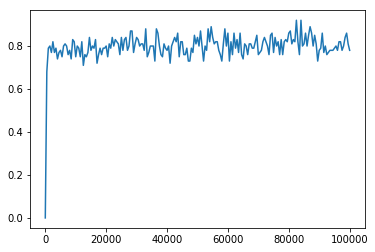

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

total_n_episodes, average_episode_return = train(
    int(1e5), player1_kwargs=dict(step_size=0.0, epsilon=1.0), player2_kwargs=dict(epsilon=0.0))
plt.plot(total_n_episodes, average_episode_return)
plt.show()

Curiosamente, a figura acima mostra que o agente guloso consegue ganhar a maioria, mas não todas, das partidas a partir de um certo ponto no treinamento. Isso pode ser devido ao fato que o adversário é sempre o primeiro a jogar, portanto em alguns jogos acaba escolhendo, por acaso, uma sequência de jogadas que impede o agente de ganhar. O melhor resultado, nesses casos, é o empate, cujo valor é 0 para o agente.

Para obter uma estimativa melhor do desempenho do agente ao final do treinamento, 1000 episódios são simulados abaixo sem que nenhum jogador aprenda, i.e. `backup` nunca é chamado, e os agentes utilizam apenas as ações consideradas melhores, i.e. $\epsilon = 0.0$. As frequências de vitória são contabilizadas para todos os episódios.

In [3]:
ttt.compete(int(1e3))

1000 turns, player 1 win 0.09, player 2 win 0.76


## Guloso vs Padrão

Abaixo o agente guloso é testado contra o agente padrão da implementação original, para 0 qual $\epsilon = 0.01$ e $\alpha = 0.1$. Nesse contexto, ambos os jogadores atualizam suas estimativas, e espera-se que os jogos terminem cada vez mais em empates na medida que os jogadores aprendem melhores políticas.

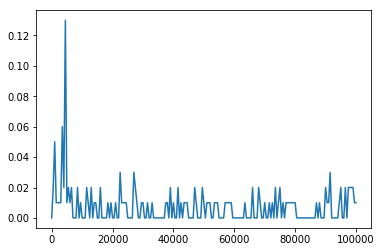

In [4]:
total_n_episodes, average_episode_return = train(
    int(1e5), player2_kwargs=dict(epsilon=0.0))
plt.plot(total_n_episodes, average_episode_return)
plt.show()

Note que há um salto na frequência inicial de vitórias do agente. Isso pode ser devido ao fato que o agente começa explorando as ações que estima serem melhores, enquanto seu adversário faz um pouco de exploração das outras ações. Entretanto, a frequência de vitórias cai na medida em que o adversário obtém melhores estimativas da função valor. 

Note que com certa frequência o agente ainda consegue vitórias. Como o adversário escolhe ações uniformente ao acaso com probabilidade 0.1 durante o treinamento, isso pode explicar porque o agente tem a oportunidade de vencer em alguns casos. Abaixo estão resultados 
de 1000 episódios nos quais ambos os jogadores mantém suas estimativas aprendidas anteriormente e agem gulosamente, mostrando que se o adversário só escolher as melhores ações, o agente não tem oportunidade de vencer. 

In [5]:
ttt.compete(int(1e3))

1000 turns, player 1 win 0.00, player 2 win 0.00


## Guloso vs Guloso

Finalmente, o agente guloso é treinado contra uma cópia dele mesmo. Novamente, espera-se que os jogos terminem cada vez mais em empates conforme os jogadores obtenham melhores políticas.

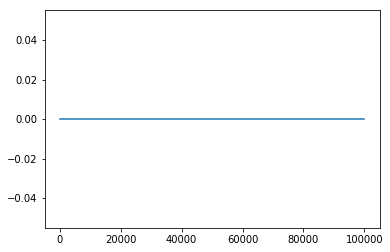

In [6]:
total_n_episodes, average_episode_return = train(
    int(1e5), player1_kwargs=dict(epsilon=0.0), player2_kwargs=dict(epsilon=0.0))
plt.plot(total_n_episodes, average_episode_return)
plt.show()

Curiosamente, em nenhum momento o agente consegue atingir a vitória, provalmente porque ambos exploram imediatamente as ações com maior valor estimado. O mesmo resultado é observado abaixo ao testar ambos com a função `compete`, como nos experimentos anteriores.

In [7]:
ttt.compete(int(1e3))

1000 turns, player 1 win 0.00, player 2 win 0.00
